In [1]:
# !wget https://files.rcsb.org/download/2JOF.pdb

In [2]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

pdb = PDBFile("Input/2JOF.pdb")

In [3]:
# Specify the forcefield
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

In [4]:
# Clean up (strip out waters)
modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()
residues=modeller.addHydrogens(forcefield)

In [5]:
# Solvation
modeller.addSolvent(forcefield, padding=1.0*nanometer)

In [6]:
# Setup system and Integrator

system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

In [7]:
# Local energy minimization

print("Minimizing energy")

# The class can have any name but it must subclass MinimizationReporter.
class MyMinimizationReporter(MinimizationReporter):

    # within the class you can declare variables that persist throughout the
    # minimization

    energies = [] # array to record progress

    # you must override the report method and it must have this signature.
    def report(self, iteration, x, grad, args):
        '''
        the report method is called every iteration of the minimization.
        
        Args:
            iteration (int): The index of the current iteration. This refers 
                             to the current call to the L-BFGS optimizer.
                             Each time the minimizer increases the restraint strength, 
                             the iteration index is reset to 0.

            x (array-like): The current particle positions in flattened order: 
                            the three coordinates of the first particle, 
                            then the three coordinates of the second particle, etc.

            grad (array-like): The current gradient of the objective function 
                               (potential energy plus restraint energy) with 
                               respect to the particle coordinates, in flattened order.

            args (dict): Additional statistics described above about the current state of minimization. 
                         In particular:
                         “system energy”: the current potential energy of the system
                         “restraint energy”: the energy of the harmonic restraints
                         “restraint strength”: the force constant of the restraints (in kJ/mol/nm^2)
                         “max constraint error”: the maximum relative error in the length of any constraint

        Returns:
            bool : Specify if minimization should be stopped.
        '''

        # Within the report method you write the code you want to be executed at 
        # each iteration of the minimization.
        # In this example we get the current energy, print it to the screen, and save it to an array. 

        current_energy = args['system energy']
        
        # with open('em_log.txt', 'w') as f:
        if iteration % 100 == 0: # only print to screen every 100 iterations for clarity of webpage display
            print(iteration, current_energy) 

        self.energies.append(current_energy)

        # The report method must return a bool specifying if minimization should be stopped. 
        # You can use this functionality for early termination.
        return False

reporter = MyMinimizationReporter()

simulation.minimizeEnergy(reporter=reporter)

Minimizing energy
0 -35051.47343508283
100 -57546.82272743284
200 -60471.16671450139
300 -61641.85627348781
400 -62208.98290011157
500 -62508.79112509723
600 -62694.756002588416
700 -62823.63041013395
800 -62916.715827676206
900 -63015.831675478454
0 -32279.820994882873
100 -48322.33900630264
200 -51729.17549886301
300 -53576.99521151195
400 -54777.260057390384
500 -55733.55328442541
600 -56269.52726250806
700 -56658.901346643695
800 -57039.782740187395
900 -57327.281627633645
1000 -57511.08853968776
1100 -57675.17648773015
1200 -57794.87271423274
1300 -57889.36579090199
1400 -57994.33001850801
1500 -58064.51386396032
1600 -58142.963674709164
1700 -58225.77519481429
1800 -58307.29733528372
1900 -58415.408714416575
2000 -58507.43129730039
2100 -58584.834342505244
2200 -58647.731730943844
2300 -58706.63180401879
2400 -58761.70992600318
2500 -58811.52481035227
2600 -58843.97578518882
2700 -58871.414712420235
2800 -58913.74232923678
2900 -58957.74000478548
0 -58705.33397972487
0 -58545.779

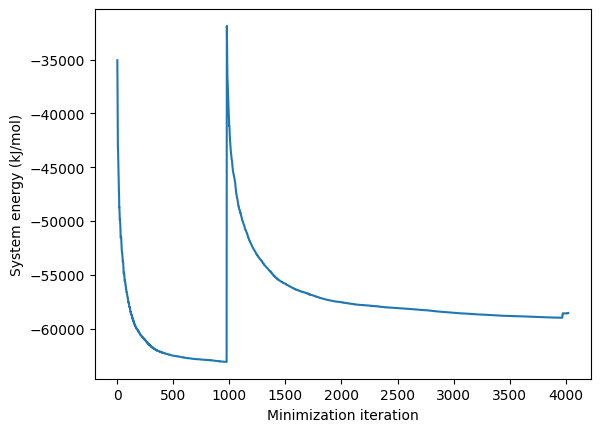

In [8]:
import matplotlib.pyplot as plt
plt.plot(reporter.energies)
plt.ylabel("System energy (kJ/mol)")
plt.xlabel("Minimization iteration")
plt.show()

In [9]:
# Set up reporters (it does not record everything as Gromacs in .edr!)

simulation.reporters.append(PDBReporter('output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True, density=True))
simulation.reporters.append(StateDataReporter("md_log.txt", 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, density=True))

In [10]:
# NVT equilibration for 40 ps

print("Running NVT")
simulation.step(10000)

Running NVT
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
1000,-49875.78411980866,295.55343405704775,36.35179510868867,0.9108282654433746
2000,-49621.70569459642,299.1949589897843,36.35179510868867,0.9108282654433746
3000,-49803.627317080754,303.43781825841864,36.35179510868867,0.9108282654433746
4000,-49871.87154684845,293.3709523722155,36.35179510868867,0.9108282654433746
5000,-49714.8455741044,302.6677647012033,36.35179510868867,0.9108282654433746
6000,-49726.098138858644,298.9687655774568,36.35179510868867,0.9108282654433746
7000,-49687.594653624736,310.32222869666543,36.35179510868867,0.9108282654433746
8000,-49822.06934490405,302.68588041649116,36.35179510868867,0.9108282654433746
9000,-49917.82650291816,296.3438345433461,36.35179510868867,0.9108282654433746
10000,-49582.15578423395,305.7585683748832,36.35179510868867,0.9108282654433746


In [ ]:
# NPT production run (with addition of a barostat) for 10 ns

system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
simulation.context.reinitialize(preserveState=True)


print("Running NPT")
simulation.step(2500000)

Running NPT
11000,-50621.398962633546,300.56619119476693,33.480265132635296,0.988948037102766
12000,-50876.5498354404,300.77439789301644,32.25652691142273,1.0264664443113
13000,-50702.18160268903,302.27919785659896,32.15330239274322,1.0297617980314397
14000,-50732.32899440173,306.5753977430015,32.31853933890824,1.0244968727512536
15000,-50926.3552963168,306.937542734131,32.467979217066556,1.019781436449722
16000,-50742.403467435084,300.78028056486727,31.827140349074035,1.04031471635381
17000,-50434.77510082869,297.32166675355506,32.58883073285882,1.0159997072621358
18000,-51043.81783505669,308.25971777719207,32.119558155163475,1.0308436474951048
19000,-51286.35288375382,299.64034281297285,31.994821714351886,1.0348625405762968
20000,-50790.658237568205,300.2595131053435,32.00327779959119,1.0345891034018648
21000,-51078.86166594976,297.0636413945411,32.45680823687966,1.0201324246965762
22000,-50907.627148996355,298.76736829934805,32.31910306331004,1.0244790030137918
23000,-51130.60477600

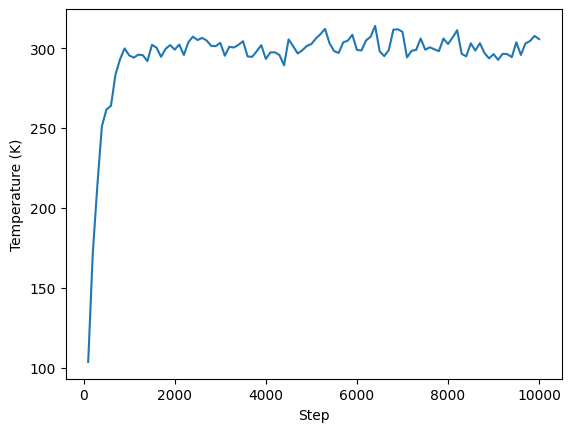

<Figure size 640x480 with 0 Axes>

In [22]:
# Temprerature during NVT equilibration

import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt("Data/md_log.txt", delimiter=',')

step = data[0:100,0]
temperature = data[0:100,2]

plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.show()
plt.savefig('Figures/Density_during_NVT_eq.png')

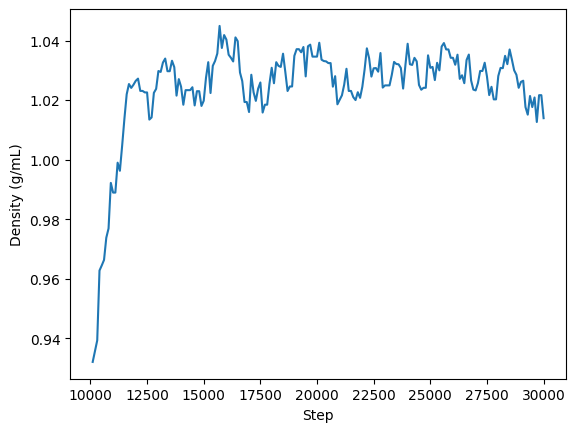

<Figure size 640x480 with 0 Axes>

In [24]:
# Density during NPT equilibration

data = np.loadtxt("Data/md_log.txt", delimiter=',')

step = data[100:300,0]
temperature = data[100:300,4]

plt.plot(step, temperature)
plt.xlabel("Step")
plt.ylabel("Density (g/mL)")
plt.show()
plt.savefig('Figures/Density_during_NPT_eq.png')

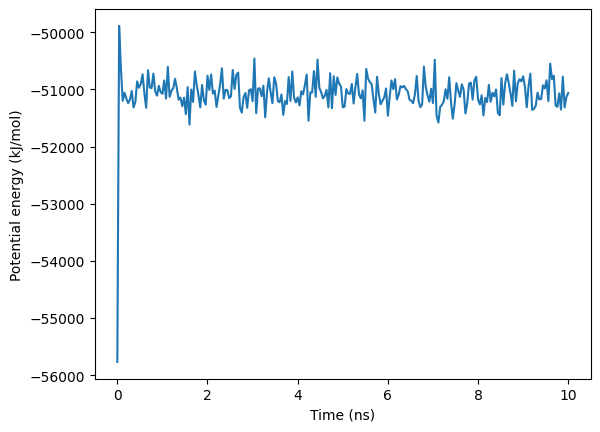

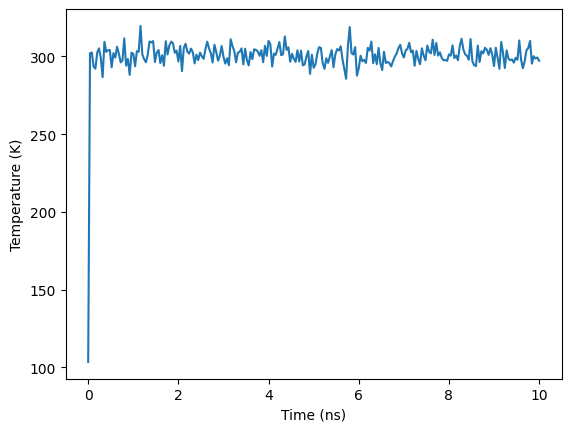

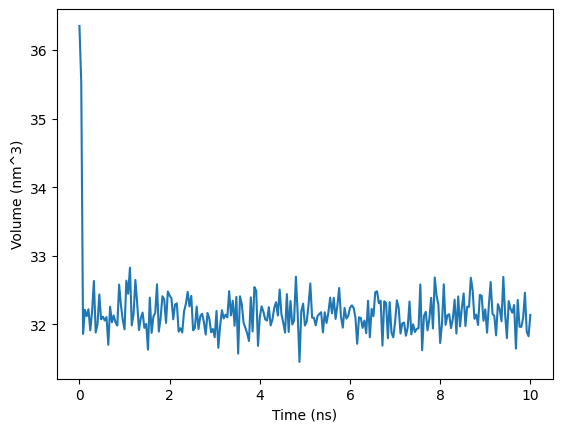

In [11]:
# Volume, density, and potential energy as in the OpenMM tutorial

data = np.loadtxt("Data/md_log.txt", delimiter=',')

step = data[:,0][::100] * 0.004 * 10**(-3)     # time in ns
potential_energy = data[:,1][::100]
temperature = data[:,2][::100]
volume = data[:,3][::100]

plt.plot(step, potential_energy)
plt.xlabel("Time (ns)")
plt.ylabel("Potential energy (kJ/mol)")
plt.show()
plt.plot(step, temperature)
plt.xlabel("Time (ns)")
plt.ylabel("Temperature (K)")
plt.show()
plt.plot(step, volume)
plt.xlabel("Time (ns)")
plt.ylabel("Volume (nm^3)")
plt.show()

In [1]:
import mdtraj as md
import matplotlib.pyplot as plt
import numpy as np

t = md.load('Data/trajectory_10_ns_no_water.pdb')

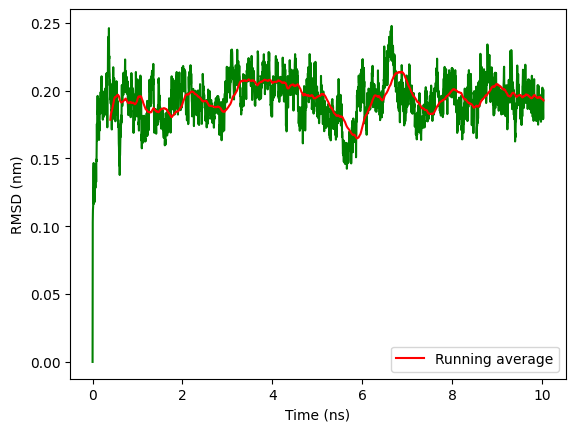

<Figure size 640x480 with 0 Axes>

In [25]:
# RMSD analysis for ALL atoms (except water) with respect to crystal structure

rmsds_crystal = md.rmsd(t, t, 0)

step = np.arange(0,2510,1) * 0.004     # in ns!!

def moving_average(a, n):
    N = len(a)
    return np.array([np.mean(a[i:i+n]) for i in np.arange(0,N-n+1)])

plt.plot(step, rmsds_crystal, color = 'green')
plt.plot(step[99:], moving_average(rmsds, 100), color = 'red', label = 'Running average')
plt.xlabel("Time (ns)")
plt.ylabel("RMSD (nm)")
plt.legend()
plt.show()
plt.savefig('Figures/RMSD_to_crystal.png')

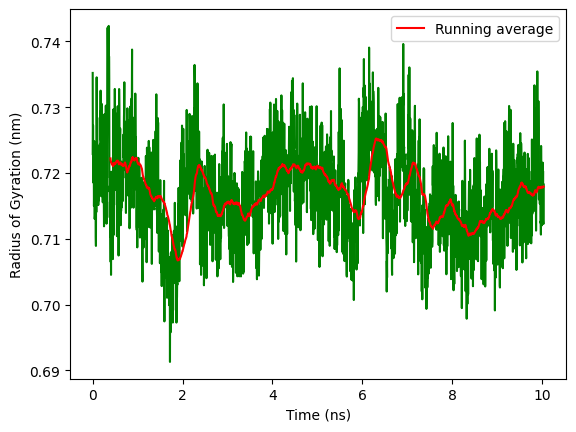

<Figure size 640x480 with 0 Axes>

In [26]:
rg = md.compute_rg(t)

step = np.arange(0,2510,1) * 0.004     # in ns!!

def moving_average(a, n):
    N = len(a)
    return np.array([np.mean(a[i:i+n]) for i in np.arange(0,N-n+1)])

plt.plot(step, rg, color = 'green')
plt.plot(step[99:], moving_average(rg, 100), color = 'red', label = 'Running average')
plt.xlabel("Time (ns)")
plt.ylabel("Radius of Gyration (nm)")
plt.legend()
plt.show()
plt.savefig('Figures/Rg.png')